In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
columns = ['vibration']

In [ ]:
df_faulty = pd.read_csv('faultydata_.csv', header= None, names= columns)
df_healthy = pd.read_csv('healthydata_.csv', header= None, names= columns)
print(df_faulty.head())
print(df_healthy.head())


   vibration
0   0.347680
1  -0.742907
2  -0.424303
3  -0.269274
4  -0.011706
   vibration
0   0.554674
1   0.056531
2   0.436170
3  -0.176623
4   0.056531


**Faulty** **Data**

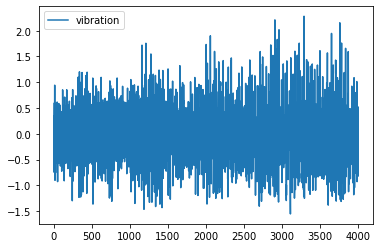

In [ ]:
fig, ax = plt.subplots()
df_faulty.plot(legend=True, ax=ax)
plt.show()

**Healthy** **Data**

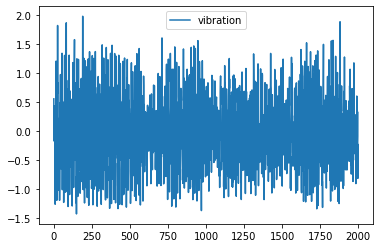

In [ ]:
fig, ax = plt.subplots()
df_healthy.plot(legend=True, ax=ax)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(df_healthy)
scaled_data=scaler.transform(df_healthy)
scaled_data


array([[0.58208004],
       [0.43618137],
       [0.54737192],
       ...,
       [0.17983837],
       [0.26814727],
       [0.35037823]])

In [ ]:
scaler.fit(df_faulty)
scaled_data1=scaler.transform(df_faulty)
scaled_data1


array([[0.49607869],
       [0.21173446],
       [0.29480264],
       ...,
       [0.37587129],
       [0.35072805],
       [0.28930214]])

**Normalization**

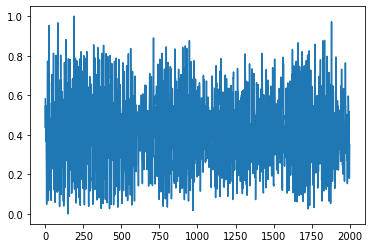

In [ ]:
plt.plot(scaled_data) # plotting by columns healthy
plt.show()

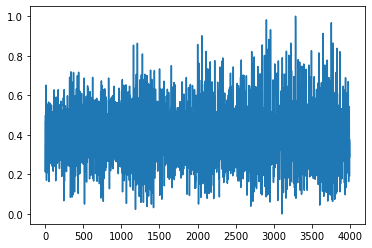

In [ ]:
plt.plot(scaled_data1) # plotting by columns faulty
plt.show()

In [ ]:
X_train = pd.DataFrame()

In [ ]:
x_list = []
from scipy import stats
train_labels = []
df_train = scaled_data

window_size = 100
step_size = 50
# creating overlaping windows of size window-size 100
for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train[i: i + 100]
    label = stats.mode(df_train[i: i + 100])[0][0]

    x_list.append(xs)
    train_labels.append(label)


In [ ]:
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())

In [ ]:
# Normalize and save the mean and std we get for normalizing test data.
training_mean = df_healthy.mean()
training_std = df_healthy.std()
df_training_value = (df_healthy - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 2001


**Training the model**

In [ ]:
TIME_STEPS = 280

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (1722, 280, 1)


In [ ]:
x_train

array([[[ 0.88904051],
        [ 0.09264936],
        [ 0.69958547],
        ...,
        [ 0.07703915],
        [-0.08689215],
        [-0.31912815]],

       [[ 0.09264936],
        [ 0.69958547],
        [-0.2800992 ],
        ...,
        [-0.08689215],
        [-0.31912815],
        [-0.91240333]],

       [[ 0.69958547],
        [-0.2800992 ],
        [ 0.09264936],
        ...,
        [-0.31912815],
        [-0.91240333],
        [ 1.00988635]],

       ...,

       [[ 0.42052636],
        [ 1.20310318],
        [-0.22153789],
        ...,
        [ 0.53176778],
        [-0.61379976],
        [-1.30660466]],

       [[ 1.20310318],
        [-0.22153789],
        [ 0.03802002],
        ...,
        [-0.61379976],
        [-1.30660466],
        [-0.82456856]],

       [[-0.22153789],
        [ 0.03802002],
        [ 1.16602351],
        ...,
        [-1.30660466],
        [-0.82456856],
        [-0.37570903]]])

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 140, 32)           256       
_________________________________________________________________
dropout_16 (Dropout)         (None, 140, 32)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 70, 16)            3600      
_________________________________________________________________
conv1d_transpose_24 (Conv1DT (None, 140, 16)           1808      
_________________________________________________________________
dropout_17 (Dropout)         (None, 140, 16)           0         
_________________________________________________________________
conv1d_transpose_25 (Conv1DT (None, 280, 32)           3616      
_________________________________________________________________
conv1d_transpose_26 (Conv1DT (None, 280, 1)           

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=40,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/40
13/13 [==============================] - 2s 88ms/step - loss: 0.9082 - val_loss: 0.8305
Epoch 2/40
13/13 [==============================] - 1s 71ms/step - loss: 0.5334 - val_loss: 0.4688
Epoch 3/40
13/13 [==============================] - 1s 72ms/step - loss: 0.3561 - val_loss: 0.2856
Epoch 4/40
13/13 [==============================] - 1s 71ms/step - loss: 0.2521 - val_loss: 0.1536
Epoch 5/40
13/13 [==============================] - 1s 70ms/step - loss: 0.1953 - val_loss: 0.1249
Epoch 6/40
13/13 [==============================] - 1s 71ms/step - loss: 0.1686 - val_loss: 0.1072
Epoch 7/40
13/13 [==============================] - 1s 71ms/step - loss: 0.1501 - val_loss: 0.0878
Epoch 8/40
13/13 [==============================] - 1s 70ms/step - loss: 0.1355 - val_loss: 0.0742
Epoch 9/40
13/13 [==============================] - 1s 73ms/step - loss: 0.1240 - val_loss: 0.0618
Epoch 10/40
13/13 [==============================] - 1s 70ms/step - loss: 0.1142 - val_loss: 0.0530
Epoch 11/

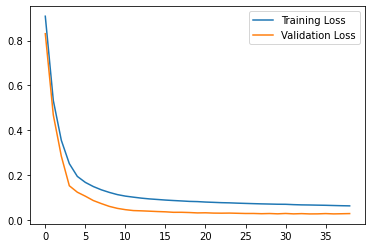

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

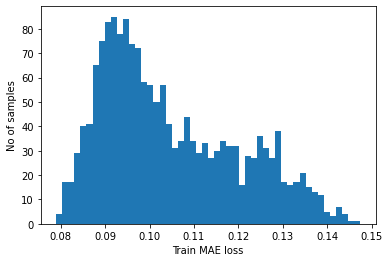

Reconstruction error threshold:  0.14746003024009363


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

**Reconstruction**

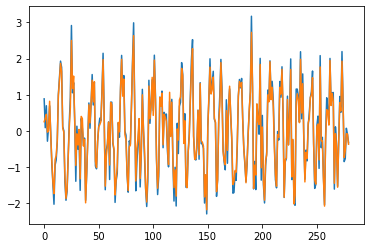

In [ ]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

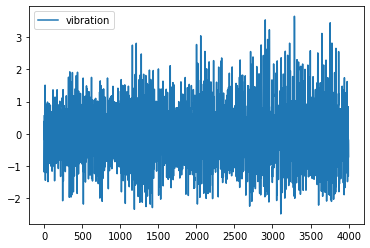

Test input shape:  (3721, 280, 1)


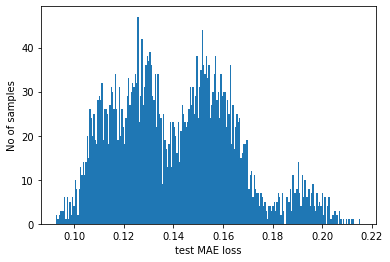

Number of anomaly samples:  1549
Indices of anomaly samples:  (array([ 917,  919,  920, ..., 3718, 3719, 3720]),)


In [ ]:
df_test_value = (df_faulty- training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=True, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=228)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
TIME_STEPS=5
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

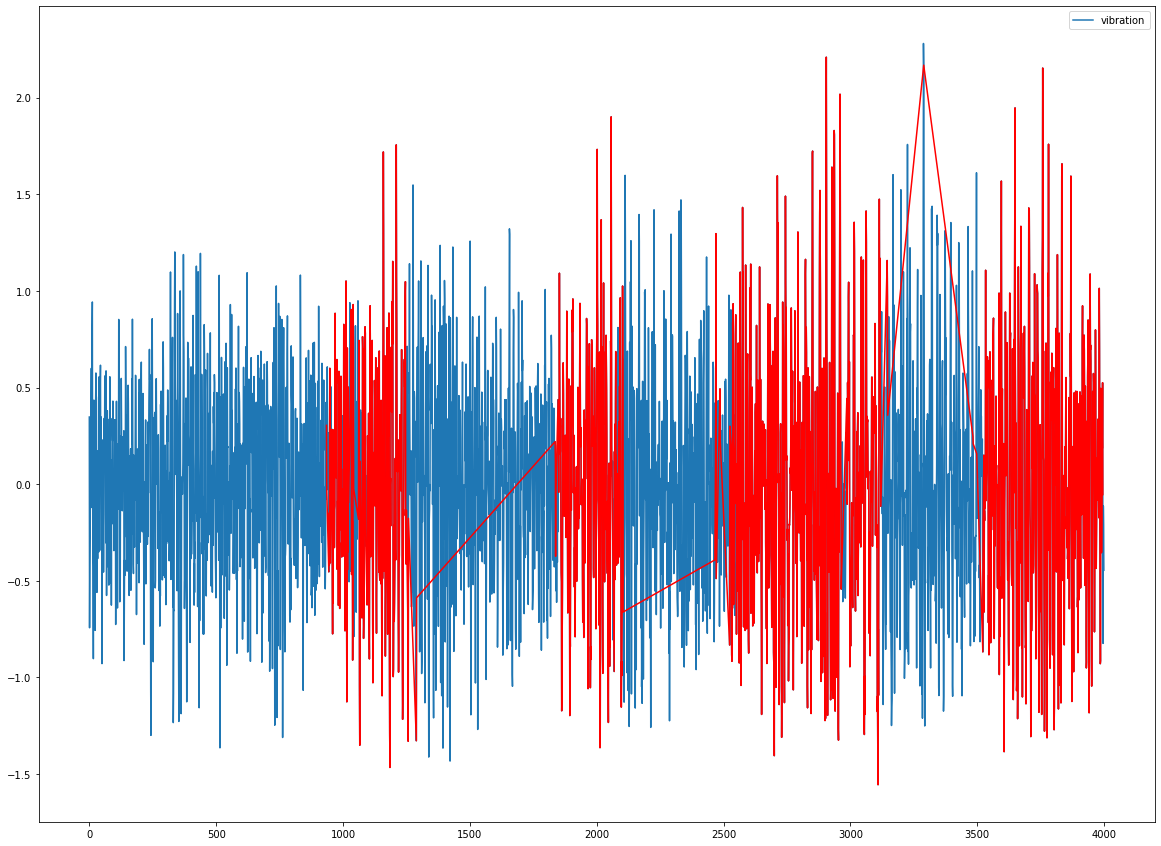

In [ ]:

df_subset = df_faulty.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_faulty.plot(legend=True, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
fig.set_figheight(15)
fig.set_figwidth(20)
plt.show()

